In [1]:
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import evaltools as et, viz_tools
import cmocean as cmo
import datetime as dt
import netCDF4 as nc
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cmocean
import pandas as pd
import pickle
import os
import gsw

%matplotlib inline

#### definitions for matching model output

In [2]:
# path to model files:
PATH= '/results/SalishSea/nowcast-green.201812/'

# start and end dates for analysis:
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2016,1,1)

# number of days per model file:
flen=1

# dictionary mapping desired model variables to the file types where they are found
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T',
         'flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}

# dictionary mapping model file types to their time resolution in hours (1 is hourly files, 24 is daily)
fdict={'ptrc_T':1,'grid_T':1}

# results format
# -- nowcast: files like 01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc
# -- long: files like SalishSea_1h_20150206_20150804_ptrc_T_20150427-20150506.nc, all in one directory
namfmt='nowcast'


### load WADE nutrient data and create csv file

In [3]:
def interpCTDvar(sta,yr,yd,ztarget,ctdvar):
    ctdlocs=(dfCTD.Station==sta)&(dfCTD.Year==yr)&(dfCTD.YD==yd)
    if np.sum(ctdlocs)==0:
        print(f'Warning: Station {sta}, Year {yr}, year day {yd} not found in dfCTD')
        return np.nan
    else:
        val=np.interp(ztarget,dfCTD.loc[ctdlocs,['Z']].values.flatten(),
                  dfCTD.loc[ctdlocs,[ctdvar]].values.flatten())
        return val

In [4]:
dfs=dict()
for year in range(2015,2019):
    PATH= '/results2/SalishSea/nowcast-green.201905/'
    datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'
    dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb'))
    dfBot=pickle.load(open(os.path.join(datadir,f'Bottles_{str(year)}.p'),'rb'))
    dfs[year]=pd.merge(left=dfSta,right=dfBot,how='right',
                 left_on='Station',right_on='Station')
    #right join means all rows in right table (dfBot) are included in output
    # drop rows with null UTCDateTime:
    ibad=dfs[year].loc[pd.isnull(dfs[year]['UTCDateTime'])].index
    dfs[year].drop(index=ibad,inplace=True)
    #dfs[year]['UTCDateTime']=[iiD+dt.timedelta(hours=20) if pd.isnull(iiU) else iiU \
    #                for iiU,iiD in zip(dfs[year]['UTCDateTime'],dfs[year]['Date'])]
    dfs[year].rename(columns={'UTCDateTime':'dtUTC','Latitude':'Lat','Longitude':'Lon'},inplace=True)
    dfs[year]['Z']=-1*dfs[year]['Z']
    dfs[year]['NO23']=dfs[year]['NO3(uM)D']+dfs[year]['NO2(uM)D'] # the model does not distinguish between NO2 and NO3
    dfs[year]['Amm']=dfs[year]['NH4(uM)D']
    dfs[year]['Si']=dfs[year]['SiOH4(uM)D']
    dfs[year]['Year']=[ii.year for ii in dfs[year]['dtUTC']]
    dfs[year]['YD']=et.datetimeToYD(dfs[year]['dtUTC'])
    dfCTD0=pickle.load(open(os.path.join(datadir,f'Casts_{str(year)}.p'),'rb'))
    dfCTD=pd.merge(left=dfSta,right=dfCTD0,how='right',
                 left_on='Station',right_on='Station')
    dfCTD['dtUTC']=[iiD+dt.timedelta(hours=20) for iiD in dfCTD['Date']]
    dfCTD.rename(columns={'Latitude':'Lat','Longitude':'Lon'},inplace=True)
    dfCTD['Z']=-1*dfCTD['Z']
    # Calculate Absolute (Reference) Salinity (g/kg) and Conservative Temperature (deg C) from 
    # Salinity (psu) and Temperature (deg C):
    press=gsw.p_from_z(-1*dfCTD['Z'],dfCTD['Lat'])
    dfCTD['SA']=gsw.SA_from_SP(dfCTD['Salinity'],press,
                               dfCTD['Lon'],dfCTD['Lat'])
    dfCTD['CT']=gsw.CT_from_t(dfCTD['SA'],dfCTD['Temperature'],press)

    dfCTD['Year']=[ii.year for ii in dfCTD['dtUTC']]
    dfCTD['YD']=et.datetimeToYD(dfCTD['dtUTC'])
    # check that there is never more than one ctd cast per station per day:
    test=dfCTD.groupby(['Station','Year','YD','Z']).count()
    print('this should be 1: ',test['Date'].unique())
    dfs[year]['SA']=[interpCTDvar(sta,yr,yd,ztarget,'SA') for sta, yr, yd, ztarget \
               in zip(dfs[year]['Station'],dfs[year]['Year'],dfs[year]['YD'],dfs[year]['Z'])]
    dfs[year]['CT']=[interpCTDvar(sta,yr,yd,ztarget,'CT') for sta, yr, yd, ztarget \
               in zip(dfs[year]['Station'],dfs[year]['Year'],dfs[year]['YD'],dfs[year]['Z'])]

this should be 1:  [1]
this should be 1:  [1]
this should be 1:  [1]
this should be 1:  [1]


In [5]:
dfAll=pd.concat((dfs[2015],dfs[2016],dfs[2017],dfs[2018]),ignore_index=True)

In [6]:
# drop Willapa Bay and Grays Harbor Stations
irem=[ii.startswith('WPA')|ii.startswith('GYS') for ii in dfAll['Station']]
inds=dfAll.loc[irem].index
dfAll.drop(index=inds,inplace=True)

In [17]:
dfTime=pd.read_excel('/ocean/eolson/MEOPAR/obs/WADE/WDE_Data/OlsonSuchyAllen_UBC_PDR_P003790-010721.xlsx',
                    engine='openpyxl',sheet_name='EventDateTime')

In [18]:
inc=np.unique(dfTime['SiteCode'])

In [19]:
set(('PSS019', 'ELB015', 'EAP001', 'PSB003', 'CMB003', 'ADM003', 'SKG003', 'SAR003',
     'BLL009', 'ADM001', 'GOR001', 'SIN001', 'CRR001', 'RSR837', 'PTH005',
     'NSQ002', 'HCB010', 'ADM002', 'CSE001', 'DNA001', 'BUD005', 'HCB007', 
     'GRG002', 'HCB003', 'SJF000', 'SJF001', 'SJF002', 'HCB004', 'OAK004'))-set(inc)

{'CRR001', 'CSE001', 'HCB003', 'HCB007'}

In [7]:
dfAll.drop(columns=['Desig','Descrip','Date','Max_Depth','NH4(uM)D','DIN','PO4(uM)D','Znom','Year', 'YD',
                    'SiOH4(uM)D','NO3(uM)D', 'NO2(uM)D'],inplace=True)
dfAll.to_csv('/data/eolson/results/MEOPAR/oldDBs/WADENuts.csv',index=False)

In [8]:
dfAll

,Station,Basin,Lat,Lon,dtUTC,Z,NO23,Amm,Si,SA,CT
0,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-01-20 19:14:00,27.590000,24.742761,0.010113,53.343590,29.387224,9.585230
1,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-01-20 19:14:00,10.266000,24.969131,0.010489,54.585922,29.387224,9.585230
2,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-01-20 19:14:00,1.084000,25.031562,0.015908,56.163105,30.307274,9.191911
3,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-02-12 18:04:00,30.497999,26.701244,0.021147,56.665092,27.363205,9.749393
4,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-02-12 18:04:00,8.286000,26.729269,0.026230,56.184971,27.363205,9.749393
...,...,...,...,...,...,...,...,...,...,...,...
2793,SKG003,Whidbey Basin,48.296488,-122.489605,2018-11-06 17:20:00,NaN,10.927600,1.138500,87.582400,NaN,NaN
2794,SKG003,Whidbey Basin,48.296488,-122.489605,2018-11-06 17:20:00,NaN,24.722200,0.857900,62.663900,NaN,NaN
2795,SKG003,Whidbey Basin,48.296488,-122.489605,2018-12-04 17:28:00,10.141000,12.943900,1.392200,100.564700,15.968538,7.459603
2796,SKG003,Whidbey Basin,48.296488,-122.489605,2018-12-04 17:28:00,0.605000,10.409200,1.300200,108.560600,30.599876,11.806420


### load csv file

In [9]:
df2=pd.read_csv('/data/eolson/results/MEOPAR/oldDBs/WADENuts.csv')
# convert dtUTC back to datetime
df2['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in df2['dtUTC']]
print(len(df2))
df2.head()

2798


,Station,Basin,Lat,Lon,dtUTC,Z,NO23,Amm,Si,SA,CT
0,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-01-20 19:14:00,27.590000,24.742761,0.010113,53.343590,29.387224,9.585230
1,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-01-20 19:14:00,10.266000,24.969131,0.010489,54.585922,29.387224,9.585230
2,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-01-20 19:14:00,1.084000,25.031562,0.015908,56.163105,30.307274,9.191911
3,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-02-12 18:04:00,30.497999,26.701244,0.021147,56.665092,27.363205,9.749393
4,ADM001,Admiralty Inlet,48.029813,-122.617933,2015-02-12 18:04:00,8.286000,26.729269,0.026230,56.184971,27.363205,9.749393


In [10]:
# match model output to observations and return both in a dataframe
# the model variables will have their original names prefixed by mod_, eg mod_vosaline
# the observation file names are unchanged. 
data=et.matchData(data=df2,filemap=filemap, fdict=fdict, mod_start=start_date, mod_end=end_date, 
                  mod_nam_fmt=namfmt, mod_basedir=PATH, mod_flen=flen)

(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain


In [11]:
#Chl:N ratio used later in plots: grab from appropriate namelist
mod_chl_N=et.getChlNRatio(basedir=PATH,nam_fmt=namfmt)

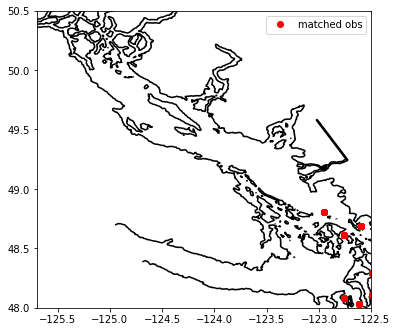

In [12]:
# plot matched data locations
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='matched obs')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, isobath=.001,coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

In [13]:
# create dictionary of dataframe views by year
datyr=dict()
yy=np.array([ii.year for ii in data['dtUTC']])
yys=np.unique(yy)
for yr in yys:
    datyr[yr]=data.loc[yy==yr]

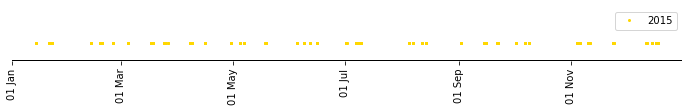

In [14]:
# plot matched data sampling times
clist=('gold','aqua','plum','c','m','r','g','b','brown','gray')
fig,axL=plt.subplots(1,1,figsize=(12,1))
for ii, yr in enumerate(yys):
    dshift=dt.datetime(yys[0],1,1)-dt.datetime(yr,1,1)
    axL.plot(datyr[yr].dtUTC+dshift,np.zeros(np.shape(datyr[yr].dtUTC))+.1*ii,'.',
             color=clist[ii],markersize=4,label=str(yr))
axL.set_yticks(());
yearsFmt = mdates.DateFormatter('%d %b')
axL.xaxis.set_major_formatter(yearsFmt)
axL.xaxis.set_ticks([dt.datetime(int(yys[0]),1,1), dt.datetime(int(yys[0]),3,1),dt.datetime(int(yys[0]),5,1),dt.datetime(int(yys[0]),7,1),
                     dt.datetime(int(yys[0]),9,1),dt.datetime(int(yys[0]),11,1),dt.datetime(int(yys[0])+1,1,1)])
for tick in axL.get_xticklabels():
        tick.set_rotation(90)
        tick.set_horizontalalignment('center')
axL.set_ylim(-.1,.1*(len(datyr.keys())+1))
axL.set_xlim(dt.datetime(yys[0],1,1),dt.datetime(yys[0],12,31))
axL.legend()
axL.set_frame_on(False)
xmin, xmax = axL.get_xaxis().get_view_interval()
ymin, ymax = axL.get_yaxis().get_view_interval()
axL.add_artist(mpl.lines.Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

#### Display stats

In [15]:
print('NO3 depth<15:') 
et.printstats(data.loc[data.Z<15,:],'NO23','mod_nitrate')
print('dSi depth<15:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')

NO3 depth<15:
  N: 375
  bias: -3.6716027751055087
  RMSE: 6.641381678951944
  WSS: 0.8295182013420677
dSi depth<15:
  N: 375
  bias: -22.948508015543222
  RMSE: 28.57976842402089
  WSS: 0.5666578974144244


### mod vs. obs plots

Text(0.5, 1.0, 'dSi ($\\mu$M)')

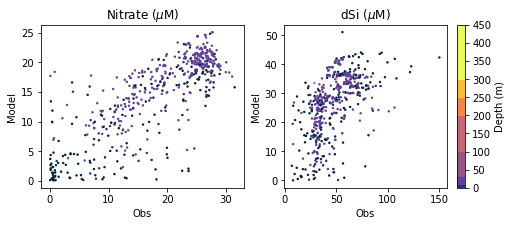

In [16]:
cm1=cmocean.cm.thermal
bounds = np.array([0,5,10,35,100,200,250,300,450])
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#pcm = ax[1].pcolormesh(X, Y, Z1, norm=norm, cmap='RdBu_r')
fig,ax=plt.subplots(1,2,figsize=(8,3))
args={'marker':'.','s':8,'norm':norm}
ps=et.varvarScatter(ax[0],data,'NO23','mod_nitrate','Z',cm=cm1,args=args)
ps=et.varvarScatter(ax[1],data,'Si','mod_silicon','Z',cm=cm1,args=args)

cb=fig.colorbar(ps,ax=ax[1],boundaries=np.linspace(0,450,46))
cb.set_label('Depth (m)')
for iax in ax:
    iax.set_ylabel('Model')
    iax.set_xlabel('Obs')
ax[0].set_title('Nitrate ($\mu$M)')
ax[1].set_title('dSi ($\mu$M)')

